In [1]:
import seaborn as sns
import torch 
import torchvision
import torch.nn as nn
from lightning_gans.models.resnet import conv_downsample, conv_upsample
import pytorch_lightning as pl
from torchinfo import summary
import tqdm
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

# 1 - Simple Autoencoder

In [2]:
class Autoencoder(pl.LightningModule):
    def __init__(self,latent_size):
        super().__init__()
        self.encoder =  torch.nn.Sequential(
            # Input = 3 x 28 x 28
            conv_downsample(ks=3,st=1,in_c=1,out_c=32),#norm=TR),
            # Input = 32 x 28 x 28
            conv_downsample(ks=3,st=2,in_c=32,out_c=64),#norm=False),
            # Input = 64 x 14 x 14
            conv_downsample(ks=3,st=2,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            conv_downsample(ks=3,st=1,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            nn.Flatten(),
            nn.Linear(in_features=64*7*7,out_features=latent_size),
            nn.Tanh()
        )
        self.decoder =  torch.nn.Sequential(
            # Input = 64 x 2 
            nn.Linear(in_features=latent_size,out_features=64*7*7),
            nn.LeakyReLU(inplace=True),
            nn.Unflatten(dim=1,unflattened_size=(64,7,7)),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=1,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=2,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 14 x 14
            conv_upsample(ks=3,st=2,in_c=64,out_c=32),#norm=False),
            # Input = 64 x 28 x 28
            conv_upsample(ks=3,st=1,in_c=32,out_c=1,norm=None,activation=None),
            nn.Sigmoid()
        )
        self.loss = nn.MSELoss()
        
    def configure_optimizers(self):
        self.opt = torch.optim.Adam(self.parameters(),lr=0.0005)
        return self.opt
    
    def training_step(self, train_batch, batch_idx):
        x,_ = train_batch
        x = self.encoder(x)
        x = self.decoder(x)
        return self.loss(train_batch[0],x)
        
    def forward(self,coords):
        return self.decoder(coords)

In [3]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
data = torchvision.datasets.MNIST('../data/raw/mnist/', train=True, download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=32,
                                          shuffle=True)
model = Autoencoder(latent_size=2)

In [4]:
trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=1,
    gpus=1,
    enable_progress_bar=True,
)
trainer.fit(model, train_dataloader=data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 99.2 K
1 | decoder | Sequential | 102 K 
2 | loss    | MSELoss    | 0     
---------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Show embedding space

  0%|          | 0/60000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='x', ylabel='y'>

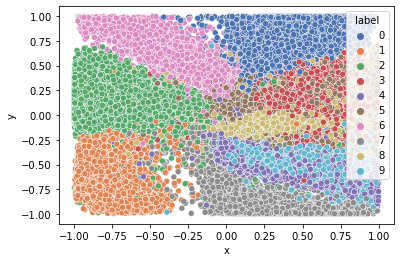

In [56]:
df = {"x":[],"y":[],"label":[]}
for x,y in tqdm.notebook.tqdm(data):
    df["label"].append(y)
    coords = model.encoder(x.cuda().unsqueeze(0)).squeeze()
    coords = coords.cpu().detach().numpy()
    df["x"].append(coords[0])
    df["y"].append(coords[1])
df = pd.DataFrame.from_dict(df)
sns.scatterplot(data=df, x="x", y="y",hue="label",palette="deep")

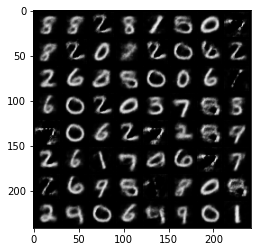

In [57]:
def generate_grid(latent_size,model):
    tmp = torch.randn(64,latent_size).cuda()
    op = model.decoder(tmp)
    grid = torchvision.utils.make_grid(op, nrow = 8, padding = 2, pad_value = 0.0)
    plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
    plt.show()
generate_grid(2,model)

# 2 - Variational Autoencoder

In [5]:
class SamplingLayer(torch.nn.Module):
    def forward(self,mu,log_vars):
        epsilon = torch.randn_like(log_vars)
        return mu + torch.exp(log_vars/2)*epsilon
    
class KLLoss(torch.nn.Module):
    def forward(self,mu,log_vars):
        tmp = 1+log_vars- mu.pow_(2)-torch.exp(log_vars)
        return -0.5 * tmp.sum(-1)
        
    
class VariationalAutoencoder(pl.LightningModule):
    def __init__(self,latent_size, r_loss_factor):
        super().__init__()
        self.encoder =  torch.nn.Sequential(
            # Input = 3 x 28 x 28
            conv_downsample(ks=3,st=1,in_c=1,out_c=32, norm=False),
            # Input = 32 x 28 x 28
            conv_downsample(ks=3,st=2,in_c=32,out_c=64,norm=False),
            # Input = 64 x 14 x 14
            conv_downsample(ks=3,st=2,in_c=64,out_c=64,norm=False),
            # Input = 64 x 7 x 7
            conv_downsample(ks=3,st=1,in_c=64,out_c=64,norm=False),
            # Input = 64 x 7 x 7
            nn.Flatten()
        )
        self.mu_layer = nn.Linear(in_features=64*7*7,out_features=latent_size)
        self.log_var_layer = nn.Linear(in_features=64*7*7,out_features=latent_size)
        self.sampling_layer = SamplingLayer()
        self.decoder =  torch.nn.Sequential(
            # Input = 64 x 2 
            nn.Linear(in_features=latent_size,out_features=64*7*7),
            nn.LeakyReLU(inplace=True),
            nn.Unflatten(dim=1,unflattened_size=(64,7,7)),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=1,in_c=64,out_c=64,norm=False),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=2,in_c=64,out_c=64,norm=False),
            # Input = 64 x 14 x 14
            conv_upsample(ks=3,st=2,in_c=64,out_c=32,norm=False),
            # Input = 64 x 28 x 28
            conv_upsample(ks=3,st=1,in_c=32,out_c=1,norm=None,activation=None),
            nn.Sigmoid()
        )
        self.r_loss = nn.MSELoss()
        self.kl_loss = KLLoss()
        self.r_loss_factor = r_loss_factor
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),
            lr=0.0005)
        return opt
    
    def training_step(self, train_batch, batch_idx):
        x,_ = train_batch
        x = self.encoder(x)
        
        mu = self.mu_layer(x)
        log_vars = self.log_var_layer(x)
        
        x = self.sampling_layer(mu,log_vars)
        
        x = self.decoder(x)
        
        r_loss = self.r_loss(train_batch[0],x)*self.r_loss_factor 
        kl_loss = self.kl_loss(mu,log_vars).mean()
        self.log("r_loss",r_loss,prog_bar=True)
        self.log("kl_loss",kl_loss,prog_bar=True)
        self.log("loss",r_loss+kl_loss,prog_bar=True)
        return r_loss+kl_loss
        
    def forward(self,inputs,decode=True):
        if decode:
            return self.decoder(inputs)
        else:
            x = self.encoder(inputs)
            mu = self.mu_layer(x)
            log_vars = self.log_var_layer(x)
            x = self.sampling_layer(mu,log_vars)
            return x

In [20]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
data = torchvision.datasets.MNIST('../data/raw/mnist/', train=True, download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=32,
                                          shuffle=True)
model = VariationalAutoencoder(latent_size=2,r_loss_factor=1000)
trainer = pl.Trainer(
    max_epochs=200,
    log_every_n_steps=100,
    gpus=1,
    enable_progress_bar=True,
)
trainer.fit(model, train_dataloader=data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | encoder        | Sequential    | 92.4 K
1 | mu_layer       | Linear        | 6.3 K 
2 | log_var_layer  | Linear        | 6.3 K 
3 | sampling_layer | SamplingLayer | 0     
4 | decoder        | Sequential    | 101 K 
5 | r_loss         | MSELoss       | 0     
6 | kl_loss        | KLLoss        | 0     
-------------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.827     T

Training: 0it [00:00, ?it/s]

/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/progress/base.py:207: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [22]:
df = {"x":[],"y":[],"label":[]}
with torch.no_grad():
    model = model.eval()
    model= model.cuda()
    
    for x,y in tqdm.notebook.tqdm(data):
        df["label"].append(y)
        coords = model(x.cuda().unsqueeze(0),decode=False).squeeze()
        coords = coords.cpu().detach().numpy()
        df["x"].append(coords[0])
        df["y"].append(coords[1])
    df = pd.DataFrame.from_dict(df)

  0%|          | 0/60000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='x', ylabel='y'>

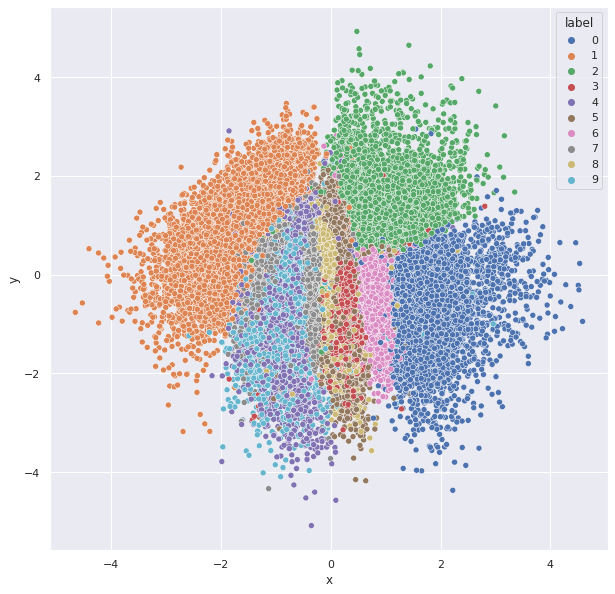

In [23]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(data=df, x="x", y="y",hue="label",palette="deep")

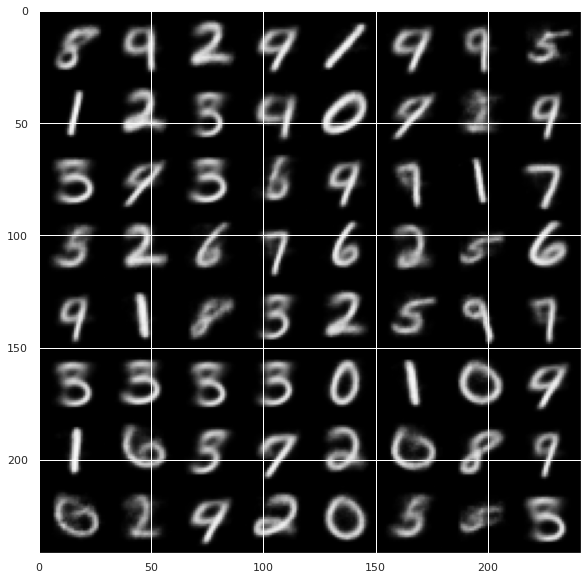

In [28]:
def generate_grid(latent_size,model):
    tmp = torch.randn(64,latent_size).cuda()
    op = model.decoder(tmp)
    grid = torchvision.utils.make_grid(op, nrow = 8, padding = 2, pad_value = 0.0)
    plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
    plt.show()
generate_grid(2,model)

# Variational Autoencoder on Faces Dataset

In [52]:
class SamplingLayer(torch.nn.Module):
    def forward(self,mu,log_vars):
        epsilon = torch.randn_like(log_vars)
        return mu + torch.exp(log_vars/2)*epsilon
    
class KLLoss(torch.nn.Module):
    def forward(self,mu,log_vars):
        tmp = 1+log_vars- mu.pow_(2)-torch.exp(log_vars)
        return -0.5 * tmp.sum(-1)
        
    
class VariationalAutoencoder(pl.LightningModule):
    def __init__(self,latent_size, r_loss_factor):
        super().__init__()
        self.encoder =  torch.nn.Sequential(
            # Input = 3 x 128 x 128
            conv_downsample(ks=3,st=2,in_c=3,out_c=32,dropout=True),
            # Input = 32 x 64 x 64
            conv_downsample(ks=3,st=2,in_c=32,out_c=64,dropout=True),
            # Input = 64 x 32 x 32
            conv_downsample(ks=3,st=2,in_c=64,out_c=64,dropout=True),
            # Input = 64 x 16 x 16
            conv_downsample(ks=3,st=2,in_c=64,out_c=64,dropout=True),
            # Input = 64 x 8 x 8
            nn.Flatten()
        )
        self.mu_layer = nn.Linear(in_features=64*8*8,out_features=latent_size)
        self.log_var_layer = nn.Linear(in_features=64*8*8,out_features=latent_size)
        self.sampling_layer = SamplingLayer()
        self.decoder =  torch.nn.Sequential(
            # Input = 64 x latent
            nn.Linear(in_features=latent_size,out_features=64*8*8),
            nn.LeakyReLU(inplace=True),
            nn.Unflatten(dim=1,unflattened_size=(64,8,8)),
            # Input = 64 x 8 x 8
            conv_upsample(ks=3,st=2,in_c=64,out_c=64,dropout=True),
            # Input = 64 x 16 x 16
            conv_upsample(ks=3,st=2,in_c=64,out_c=64,dropout=True),
            # Input = 64 x 32 x 32
            conv_upsample(ks=3,st=2,in_c=64,out_c=32,dropout=True),
            # Input = 64 x 64 x 64
            conv_upsample(ks=3,st=2,in_c=32,out_c=3,norm=None,activation=None),
            nn.Sigmoid()
        )
        self.r_loss = nn.MSELoss()
        self.kl_loss = KLLoss()
        self.r_loss_factor = r_loss_factor
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),
            lr=0.0005)
        return opt
    
    def training_step(self, train_batch, batch_idx):
        x,_ = train_batch
        x = self.encoder(x)
        
        mu = self.mu_layer(x)
        log_vars = self.log_var_layer(x)
        
        x = self.sampling_layer(mu,log_vars)
        
        x = self.decoder(x)
        
        r_loss = self.r_loss(train_batch[0],x)*self.r_loss_factor 
        kl_loss = self.kl_loss(mu,log_vars).mean()
        self.log("r_loss",r_loss,prog_bar=True)
        self.log("kl_loss",kl_loss,prog_bar=True)
        self.log("loss",r_loss+kl_loss,prog_bar=True)
        return r_loss+kl_loss
        
    def forward(self,inputs,decode=True):
        if decode:
            return self.decoder(inputs)
        else:
            x = self.encoder(inputs)
            mu = self.mu_layer(x)
            log_vars = self.log_var_layer(x)
            x = self.sampling_layer(mu,log_vars)
            return x

In [62]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128,128)),
    ])
data = torchvision.datasets.ImageFolder(root="../data/raw/celebA/img_align_celeba/", transform = transform)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=1024,
                                          shuffle=True)

In [ ]:
model = VariationalAutoencoder(latent_size=200,r_loss_factor=10000)
trainer = pl.Trainer(
    max_epochs=200,
    log_every_n_steps=100,
    gpus=1,
    enable_progress_bar=True,
    enable_checkpointing=True
)
trainer.fit(model, train_dataloader=data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | encoder        | Sequential    | 93.5 K
1 | mu_layer       | Linear        | 819 K 
2 | log_var_layer  | Linear        | 819 K 
3 | sampling_layer | SamplingLayer | 0     
4 | decoder        | Sequential    | 916 K 
5 | r_loss         | MSELoss       | 0     
6 | kl_loss        | KLLoss        | 0     
-------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.596    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

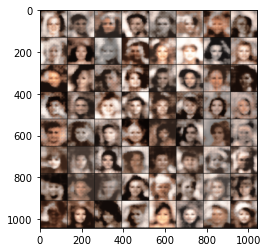

In [61]:
def generate_grid(latent_size,model):
    tmp = torch.randn(64,latent_size).cuda()
    op = model.decoder(tmp)
    grid = torchvision.utils.make_grid(op, nrow = 8, padding = 2, pad_value = 0.0)
    plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
    plt.show()
generate_grid(200,model)